<a href="https://colab.research.google.com/github/bananaEntrepreneur/LoadForecasting/blob/research/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [164]:
url = "https://raw.githubusercontent.com/bananaEntrepreneur/LoadForecasting/refs/heads/main/data/website_data.csv"
df = pd.read_csv(url)

df.head()

,Page Views,Session Duration,Bounce Rate,Traffic Source,Time on Page,Previous Visits,Conversion Rate
0,5,11.051381,0.230652,Organic,3.890460,3,1.0
1,4,3.429316,0.391001,Social,8.478174,0,1.0
2,4,1.621052,0.397986,Organic,9.636170,2,1.0
3,5,3.629279,0.180458,Organic,2.071925,3,1.0
4,5,4.235843,0.291541,Paid,1.960654,5,1.0


In [165]:
ts = pd.DataFrame()
ts["traffic"] = df["Page Views"]
ts["date"] = pd.to_datetime(pd.date_range(start="2023-01-01", periods=len(df)))
daily = ts.groupby("date")["traffic"].sum().reset_index()
daily = daily.sort_values("date")

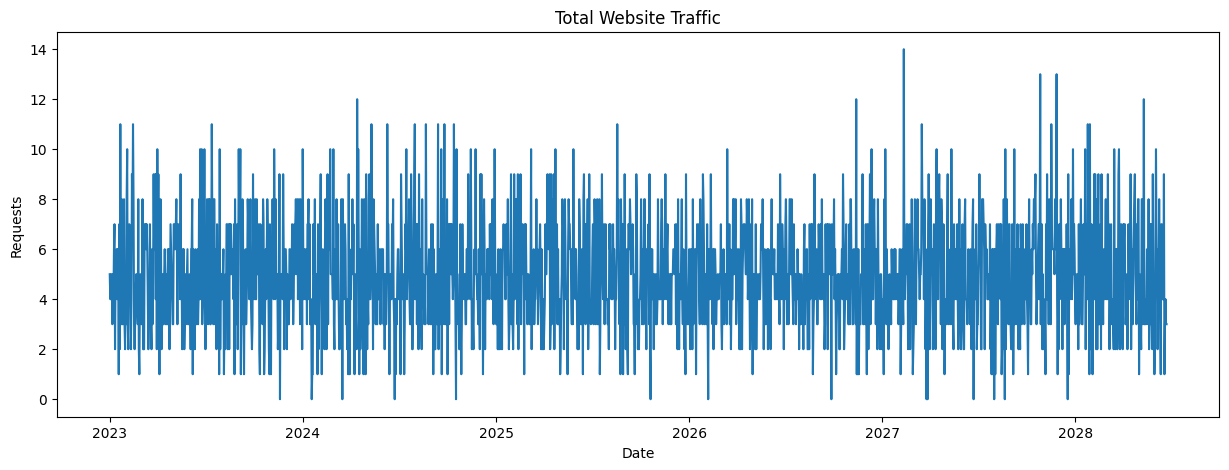

In [166]:
plt.figure(figsize=(15,5))
plt.plot(daily["date"], daily["traffic"])
plt.title("Total Website Traffic")
plt.xlabel("Date")
plt.ylabel("Requests")
plt.show()

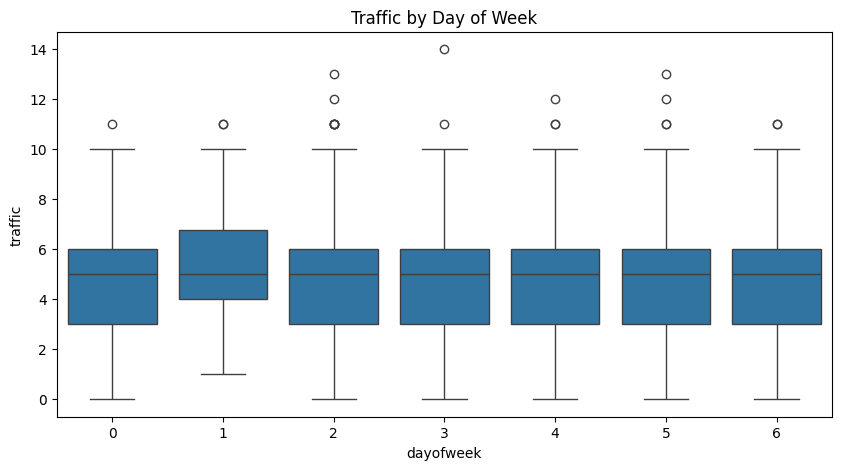

In [167]:
daily["dayofweek"] = daily["date"].dt.dayofweek

plt.figure(figsize=(10,5))
sns.boxplot(x="dayofweek", y="traffic", data=daily)
plt.title("Traffic by Day of Week")
plt.show()

In [168]:
data = daily.copy()

data["lag_1"] = data["traffic"].shift(1)
data["lag_7"] = data["traffic"].shift(7)

data["rolling_7"] = data["traffic"].rolling(7).mean()

data["dayofweek"] = data["date"].dt.dayofweek
data["month"] = data["date"].dt.month

data = data.dropna()
data.head()

,date,traffic,dayofweek,lag_1,lag_7,rolling_7,month
7,2023-01-08,4,6,5.0,5.0,4.285714,1
8,2023-01-09,6,0,4.0,4.0,4.571429,1
9,2023-01-10,7,1,6.0,4.0,5.000000,1
10,2023-01-11,2,2,7.0,5.0,4.571429,1
11,2023-01-12,5,3,2.0,5.0,4.571429,1


In [169]:
split_date = data["date"].quantile(0.8)

train = data[data["date"] <= split_date]
test = data[data["date"] > split_date]

features = ["lag_1","lag_7","rolling_7","dayofweek","month"]

X_train = train[features]
y_train = train["traffic"]

X_test = test[features]
y_test = test["traffic"]

In [170]:
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

MAE: 1.8321794271469116
RMSE: 2.267185384169682


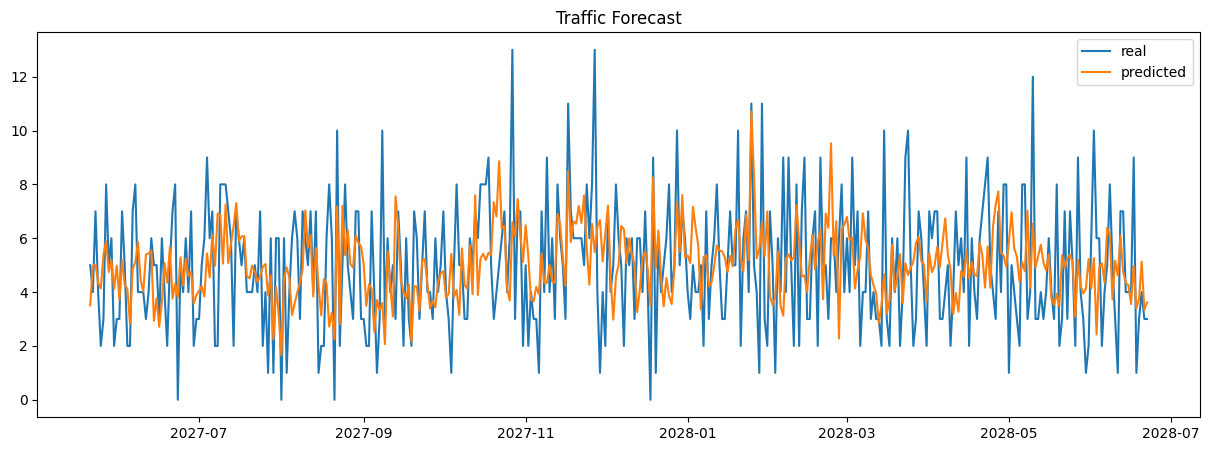

In [171]:
plt.figure(figsize=(15,5))
plt.plot(test["date"], y_test, label="real")
plt.plot(test["date"], preds, label="predicted")
plt.legend()
plt.title("Traffic Forecast")
plt.show()

In [172]:
RPS_PER_SERVER = 5000

test = test.copy()
test["predicted"] = preds
test["servers_needed"] = test["predicted"] / RPS_PER_SERVER
test["servers_needed"] = test["servers_needed"].apply(np.ceil)

test[["date","predicted","servers_needed"]].head()

,date,predicted,servers_needed
1601,2027-05-21,3.505523,1.0
1602,2027-05-22,4.982221,1.0
1603,2027-05-23,5.020018,1.0
1604,2027-05-24,4.343711,1.0
1605,2027-05-25,4.131769,1.0
